Perform experiments that show that BatchNorm can \\
(a) accelerate convergence of gradient based neural network training algorithms,
(b) can permit larger learning rates, and \\
(c) can lead to better neural network performance.  You may select any context you like for your experiments.

In [1]:
import torchvision
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data as Data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):    
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     
    transform=torchvision.transforms.ToTensor(),                                                   
    download=True,
)

test_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,                                     
    transform=torchvision.transforms.ToTensor(),                                                   
    download=True,
)

Training Data Size: torch.Size([60000, 28, 28])
Training Data Labels Size : torch.Size([60000])


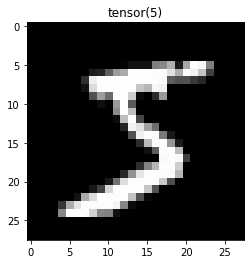

In [4]:
print("Training Data Size: {}".format(train_data.data.size()))
print("Training Data Labels Size : {}".format(train_data.targets.size()))
plt.imshow(train_data.data[0].numpy(), cmap = 'gray')
plt.title(train_data.targets[0])
plt.show()

## Parameters for the Model 

In [5]:
## CNN with two hidden layers and Relu Activation for MNIST
## training parameters

INPUT_SIZE = 784
HIDDEN_SIZE_1 = 128
HIDDEN_SIZE_2 = 64
BATCH_SIZE = 60
NUM_EPOCHS = 50
# LEARNING_R = 0.1
NUM_CLASSES = 10


seed = 1234
torch.manual_seed(seed)

In [6]:
train_data_loader = Data.DataLoader(
    dataset = train_data, 
    batch_size = BATCH_SIZE,
    shuffle = True
    ) 
test_data_loader = Data.DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)


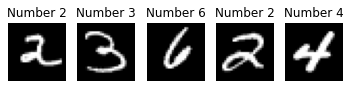

In [28]:
## Visualizing the test data
batch = next(iter(test_data_loader))
samples = batch[0][:5]
y_true = batch[1]

for i,sample in enumerate(samples):
  plt.subplot(1,5,i+1)
  plt.title("Number %i" %y_true[i])
  plt.imshow(sample.numpy().reshape((28,28)), cmap = 'gray')
  plt.axis("off")


## Neural Network Model Architecture without Batch Normalization

In [29]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, num_classes): 
        super(NeuralNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size1),  # 28 x 28 = 784 flatten the input image
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

##  Neural Network Model Architecture with Batch Normalization

In [30]:
class BatchNormNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, num_classes): 
        super(BatchNormNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1), #applying batch norm
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [31]:
model_1 = NeuralNet(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2, NUM_CLASSES)
model_1

NeuralNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [32]:
model_2 = BatchNormNet(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2, NUM_CLASSES)
model_2

BatchNormNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [33]:
def train_test(NUM_EPOCHS, MODEL_TYPE, LEARNING_R):
  
  loss_list = []
  accuracy = []
  iterations = []
  running_loss = 0.0
  total_train = 0.0
  total_test = 0.0
  test_accuracy_list = []
  correct_test = 0.0
  correct_train = 0.0
  test_accuracy = 0.0
  optimizer = optim.SGD(MODEL_TYPE.parameters(), lr = LEARNING_R, momentum=0.9)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(NUM_EPOCHS):
    for i, (image, labels) in enumerate(train_data_loader):
      train = image.reshape(-1, 28*28)
      labels = labels
      # print(train, labels)
      output = MODEL_TYPE(train)
      optimizer.zero_grad()
      loss = criterion(output, labels)
      
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      _, predicted = torch.max(output.data,1)
      total_train += labels.size(0)
      correct_train += predicted.eq(labels.data).sum().item()
      train_accuracy = 100 * correct_train / total_train

    for i, (image, labels) in enumerate(test_data_loader):
      images = image.reshape(-1, 28*28)
      output = MODEL_TYPE(images)
      _, pred = torch.max(output,1)
      total_test += labels.size(0)
      correct_test += pred.eq(labels.data).sum().item()
    test_accuracy = 100 * correct_test / total_test
    print (f"\nEpoch {epoch+1}\nTraining Loss: {running_loss/1000}\nTraining Accuracy {train_accuracy}\nTesting Accuracy {test_accuracy}")
    loss_list.append(running_loss/1000)
    accuracy.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    running_loss = 0.0

  return loss_list, accuracy, test_accuracy_list


In [27]:
loss_list, accuracy, test_accuracy_list = train_test(15, model_1, 0.01)


Epoch 1
Training Loss: 0.5435802626833319
Training Accuracy 84.245
Testing Accuracy 93.28

Epoch 2
Training Loss: 0.18813127533718943
Training Accuracy 89.40416666666667
Testing Accuracy 94.485

Epoch 3
Training Loss: 0.12843033196032047
Training Accuracy 91.67166666666667
Testing Accuracy 95.08666666666667

Epoch 4
Training Loss: 0.09702961960341781
Training Accuracy 93.03208333333333
Testing Accuracy 95.5375

Epoch 5
Training Loss: 0.07783916562329977
Training Accuracy 93.95466666666667
Testing Accuracy 95.89

Epoch 6
Training Loss: 0.06489027580828406
Training Accuracy 94.64305555555555
Testing Accuracy 96.16166666666666

Epoch 7
Training Loss: 0.05375874708965421
Training Accuracy 95.1745238095238
Testing Accuracy 96.36714285714285

Epoch 8
Training Loss: 0.0459937264820328
Training Accuracy 95.59958333333333
Testing Accuracy 96.54125

Epoch 9
Training Loss: 0.03917964295600541
Training Accuracy 95.95166666666667
Testing Accuracy 96.67888888888889

Epoch 10
Training Loss: 0.032905

In [34]:
loss_list_batch, accuracy_batch, test_accuracy_list_batch = train_test(15, model_2, 0.01)


Epoch 1
Training Loss: 0.24308478444442153
Training Accuracy 93.20666666666666
Testing Accuracy 96.49

Epoch 2
Training Loss: 0.10070806024177
Training Accuracy 95.05166666666666
Testing Accuracy 96.675

Epoch 3
Training Loss: 0.0733083789232187
Training Accuracy 95.97055555555555
Testing Accuracy 96.85

Epoch 4
Training Loss: 0.05804960775561631
Training Accuracy 96.52
Testing Accuracy 96.94

Epoch 5
Training Loss: 0.04674879469280131
Training Accuracy 96.924
Testing Accuracy 97.044

Epoch 6
Training Loss: 0.03734981960919686
Training Accuracy 97.24694444444444
Testing Accuracy 97.12166666666667

Epoch 7
Training Loss: 0.033665731187793424
Training Accuracy 97.48666666666666
Testing Accuracy 97.18428571428572

Epoch 8
Training Loss: 0.028936308094649577
Training Accuracy 97.68708333333333
Testing Accuracy 97.20125

Epoch 9
Training Loss: 0.026172564322128892
Training Accuracy 97.84611111111111
Testing Accuracy 97.2611111111111

Epoch 10
Training Loss: 0.022291810103750323
Training Ac

In [13]:
loss_list_lr, accuracy_lr, test_accuracy_list_lr = train_test(15, model_1, 0.5)


Epoch 1
Training Loss: 2.307385147035122
Training Accuracy 12.063333333333333
Testing Accuracy 9.8

Epoch 2
Training Loss: 2.318870076417923
Training Accuracy 11.169166666666667
Testing Accuracy 10.04

Epoch 3
Training Loss: 2.321061672925949
Training Accuracy 10.848888888888888
Testing Accuracy 10.12

Epoch 4
Training Loss: 2.321709380865097
Training Accuracy 10.705833333333333
Testing Accuracy 10.16

Epoch 5
Training Loss: 2.3187411880493163
Training Accuracy 10.603
Testing Accuracy 10.076

Epoch 6
Training Loss: 2.3200936992168426
Training Accuracy 10.530277777777778
Testing Accuracy 10.078333333333333

Epoch 7
Training Loss: 2.319007211923599
Training Accuracy 10.470476190476191
Testing Accuracy 10.112857142857143

Epoch 8
Training Loss: 2.3200471324920655
Training Accuracy 10.462916666666667
Testing Accuracy 9.96375

Epoch 9
Training Loss: 2.3206279332637787
Training Accuracy 10.427037037037037
Testing Accuracy 9.97888888888889

Epoch 10
Training Loss: 2.3195667493343355
Training

In [20]:
loss_list_batch_lr, accuracy_batch_lr, test_accuracy_list_batch_lr = train_test(15, model_2, 0.5)


Epoch 1
Training Loss: 0.2784119394924492
Training Accuracy 91.83666666666667
Testing Accuracy 95.15

Epoch 2
Training Loss: 0.15816073708515616
Training Accuracy 93.565
Testing Accuracy 95.515

Epoch 3
Training Loss: 0.1302526795999147
Training Accuracy 94.45277777777778
Testing Accuracy 95.72

Epoch 4
Training Loss: 0.11589078436011914
Training Accuracy 94.99875
Testing Accuracy 95.905

Epoch 5
Training Loss: 0.09642964972840855
Training Accuracy 95.448
Testing Accuracy 96.034

Epoch 6
Training Loss: 0.09108214095447328
Training Accuracy 95.75944444444444
Testing Accuracy 96.10833333333333

Epoch 7
Training Loss: 0.07996909010774107
Training Accuracy 96.03285714285714
Testing Accuracy 96.16714285714286

Epoch 8
Training Loss: 0.07975507021520753
Training Accuracy 96.234375
Testing Accuracy 96.19125

Epoch 9
Training Loss: 0.07634779434568009
Training Accuracy 96.40185185185184
Testing Accuracy 96.21777777777778

Epoch 10
Training Loss: 0.06454593713971553
Training Accuracy 96.572166

## Plotting Training Loss, Training Accuracy, Test Accuracy for Standard Model and Standard Model + Batch Normalization with two learning rates -- 0.01 & 0.5

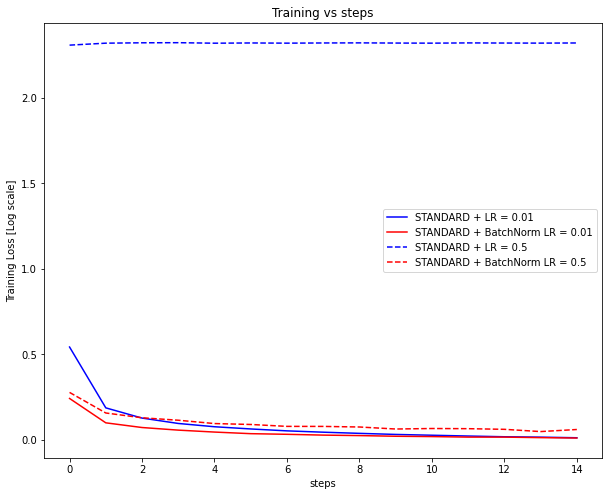

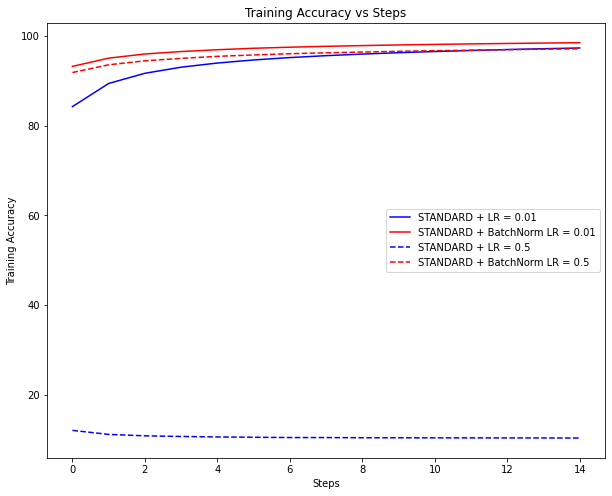

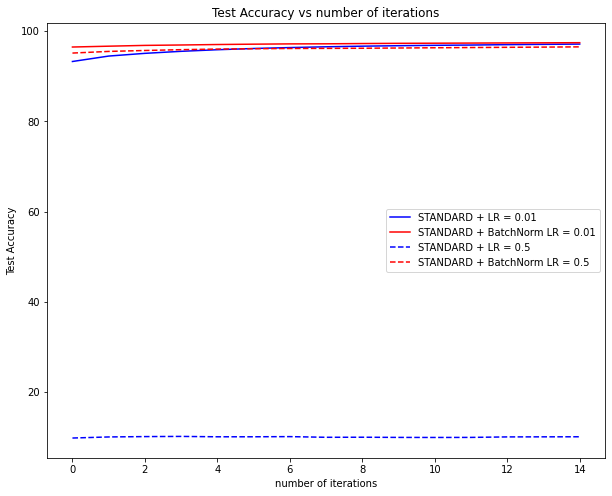

In [35]:
plt.subplots(figsize = (10,8))
plt.plot(np.array(loss_list), 'b', label='STANDARD + LR = 0.01')
plt.plot(np.array(loss_list_batch), 'r', label = 'STANDARD + BatchNorm LR = 0.01')
plt.plot(np.array(loss_list_lr), 'b', label = 'STANDARD + LR = 0.5', linestyle='--')
plt.plot(np.array(loss_list_batch_lr), 'r', label = 'STANDARD + BatchNorm LR = 0.5', linestyle='--')
plt.title('Training vs steps')
plt.xlabel('steps')
plt.ylabel('Training Loss [Log scale]')
plt.legend()
# plt.show()
plt.subplots(figsize = (10,8))
plt.plot( np.array(accuracy), 'b', label='STANDARD + LR = 0.01')
plt.plot( np.array(accuracy_batch), 'r', label = 'STANDARD + BatchNorm LR = 0.01')
plt.plot( np.array(accuracy_lr), 'b', label = 'STANDARD + LR = 0.5', linestyle='--')
plt.plot( np.array(accuracy_batch_lr), 'r', label = 'STANDARD + BatchNorm LR = 0.5' ,linestyle='--')
plt.title('Training Accuracy vs Steps')
plt.xlabel('Steps')
plt.ylabel('Training Accuracy')
plt.legend()
plt.subplots(figsize = (10,8))
plt.plot(np.array(test_accuracy_list), 'b', label='STANDARD + LR = 0.01')
plt.plot(np.array(test_accuracy_list_batch), 'r', label='STANDARD + BatchNorm LR = 0.01')
plt.plot(np.array(test_accuracy_list_lr), 'b', label='STANDARD + LR = 0.5', linestyle='--')
plt.plot(np.array(test_accuracy_list_batch_lr), 'r', label='STANDARD + BatchNorm LR = 0.5', linestyle='--')
plt.title('Test Accuracy vs number of iterations')
plt.xlabel('number of iterations')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

## Problem 2: Stochastic Gradient Descent

In this problem, you will build your own solver of Stochastic Gradient Descent.  Do not use built-in solvers from any deep learning packages.
In this problem, you will use stochastic gradient descent to solve 

$\min_y \frac{1}{n} \sum_{i=1}^n |y-x_i|^2$, 

where $x_i$ is a real number for $i=1 \ldots n$.

Generate points $x_i \sim \text{Uniform}[0,1]$ for $i = 1 \ldots 100$. Use Stochastic Gradient Descent with a constant learning rate to solve .  Use $G(y) = \frac{d}{dy} |y-x_i|^2$ for a randomly chosen $i \in \{1 \ldots n\}$.  Create a plot of MSE error (relative to $y^*$) versus iteration number for two different learning rates.  Make sure your plot clearly shows that SGD with the larger learning rate leads to faster initial convergence and a larger terminal error range than SGD with the smaller learning rate.

In [ ]:
x = np.random.uniform(0, 1, 100)
x

array([0.81242289, 0.49224719, 0.50022526, 0.03673682, 0.38437515,
       0.3301572 , 0.85307694, 0.43176919, 0.15553839, 0.8711398 ,
       0.24368733, 0.88113004, 0.7915877 , 0.15809865, 0.43641085,
       0.09947189, 0.16596453, 0.26499223, 0.67069352, 0.80045897,
       0.98175961, 0.80429001, 0.39187074, 0.38444551, 0.17915751,
       0.59141489, 0.29719122, 0.37586049, 0.14586543, 0.35315941,
       0.47115241, 0.02880125, 0.95989842, 0.27436739, 0.02325197,
       0.13087981, 0.07000763, 0.86305129, 0.56284311, 0.01021442,
       0.04896813, 0.99408011, 0.84028199, 0.19169223, 0.5881976 ,
       0.6608769 , 0.43081494, 0.47946213, 0.07956622, 0.83177287,
       0.17002237, 0.80474146, 0.67965427, 0.08120251, 0.57684593,
       0.48577558, 0.96518871, 0.68625098, 0.7595727 , 0.57482186,
       0.35926645, 0.71059353, 0.40776774, 0.04389297, 0.84894579,
       0.05554327, 0.84987062, 0.18584273, 0.9240408 , 0.71613412,
       0.44361592, 0.55939728, 0.29919322, 0.47680932, 0.64446

## Stochastic Gradient Descent code to minimize the given function

In [ ]:
import random 
def sgd(X, learning_rate, n_epochs=200):
    y = 0  # Randomly initializing weights
    epoch = 1
    loss = []
    while epoch <= n_epochs:
        temp = random.choice(X)
        Ly = 2*(y-temp)
        y = y - learning_rate * Ly
        error = np.sum((y - X)**2)/len(X)
        loss.append(error)
        print("Epoch: %d, Loss: %.3f" %(epoch, error))
        epoch+=1
    return loss

In [ ]:
loss = sgd(x, 0.01)
loss_1 = sgd(x, 0.1)
print("Loss with LR = 0.01", loss)
print("Loss with LR = 0.1", loss_1)

Epoch: 1, Loss: 0.300
Epoch: 2, Loss: 0.283
Epoch: 3, Loss: 0.277
Epoch: 4, Loss: 0.275
Epoch: 5, Loss: 0.273
Epoch: 6, Loss: 0.266
Epoch: 7, Loss: 0.264
Epoch: 8, Loss: 0.260
Epoch: 9, Loss: 0.257
Epoch: 10, Loss: 0.242
Epoch: 11, Loss: 0.234
Epoch: 12, Loss: 0.233
Epoch: 13, Loss: 0.231
Epoch: 14, Loss: 0.231
Epoch: 15, Loss: 0.230
Epoch: 16, Loss: 0.224
Epoch: 17, Loss: 0.224
Epoch: 18, Loss: 0.213
Epoch: 19, Loss: 0.213
Epoch: 20, Loss: 0.208
Epoch: 21, Loss: 0.204
Epoch: 22, Loss: 0.203
Epoch: 23, Loss: 0.192
Epoch: 24, Loss: 0.189
Epoch: 25, Loss: 0.186
Epoch: 26, Loss: 0.177
Epoch: 27, Loss: 0.171
Epoch: 28, Loss: 0.162
Epoch: 29, Loss: 0.158
Epoch: 30, Loss: 0.153
Epoch: 31, Loss: 0.147
Epoch: 32, Loss: 0.148
Epoch: 33, Loss: 0.142
Epoch: 34, Loss: 0.137
Epoch: 35, Loss: 0.135
Epoch: 36, Loss: 0.136
Epoch: 37, Loss: 0.130
Epoch: 38, Loss: 0.126
Epoch: 39, Loss: 0.127
Epoch: 40, Loss: 0.125
Epoch: 41, Loss: 0.123
Epoch: 42, Loss: 0.125
Epoch: 43, Loss: 0.127
Epoch: 44, Loss: 0.1

## Plotting Training Loss vs number of steps for two variations of Learning rate {0.04, 0.2}

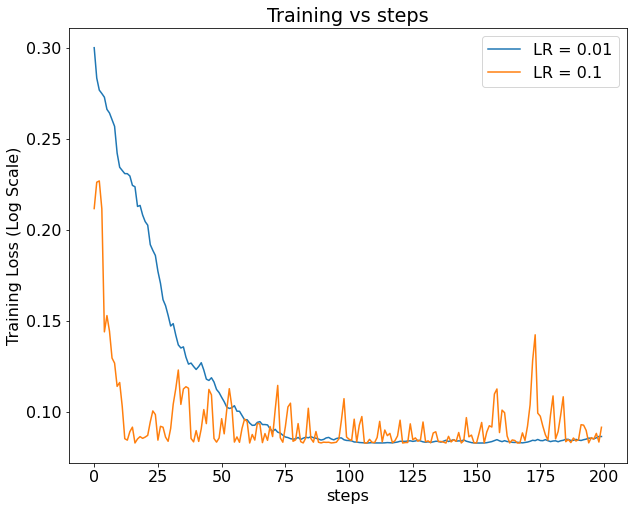

In [ ]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
plt.plot(loss,  Label='LR = 0.01')
plt.plot(loss_1,  Label='LR = 0.1')
plt.title('Training vs steps')
plt.xlabel('steps')
plt.ylabel('Training Loss (Log Scale)')
plt.legend()

## Problem 3
#### Defining function $f_1$
$f_1(x,y) = x^2 + 0.1 y^2$ \\

### Defining function $f_2$
$f_2(x,y) = \frac{(x-y)^2}{2} + 0.1 \frac{(x+y)^2}{2}$

We can observe that both the functions are convex in nature.

In [ ]:
# Objective function
def f_1(x, y):
    return (x) ** 2 + 0.1 * (y) ** 2

def f_2(x, y):
  return ((x - y)** 2)/2 + 0.1 * ((x + y)**2)/2

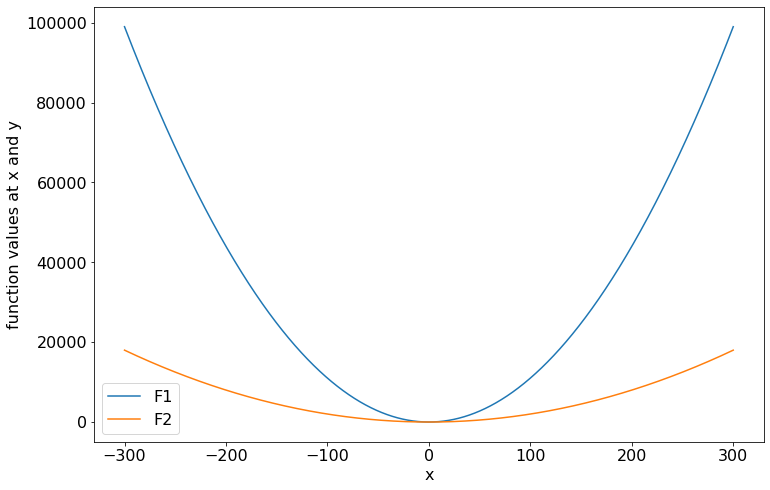

In [ ]:
x = np.arange(-300, 300, 0.01)
y = np.arange(-300, 300, 0.01)
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(x, f_1(x,y), label = "F1")
plt.plot(x, f_2(x,y), label = 'F2')
plt.legend()
plt.xlabel("x")
plt.ylabel("function values at x and y")
plt.show()

## Minimizer Function

The function takes in the function, the initial values and the optimizer as arguments and returns the list that contains loss values for 2000 iterations

In [ ]:
def minimizer(f, hp, optimizer):
  for param in hp:
    param.requires_grad = True
  obj_vals = []
  for i in range(2000):
      optimizer.zero_grad()
      loss = f(*hp)
      loss.backward()
      optimizer.step()
      obj_vals.append(loss)
  for param in hp:
      param.requires_grad = False
  return obj_vals

## Minimizing using the SGD

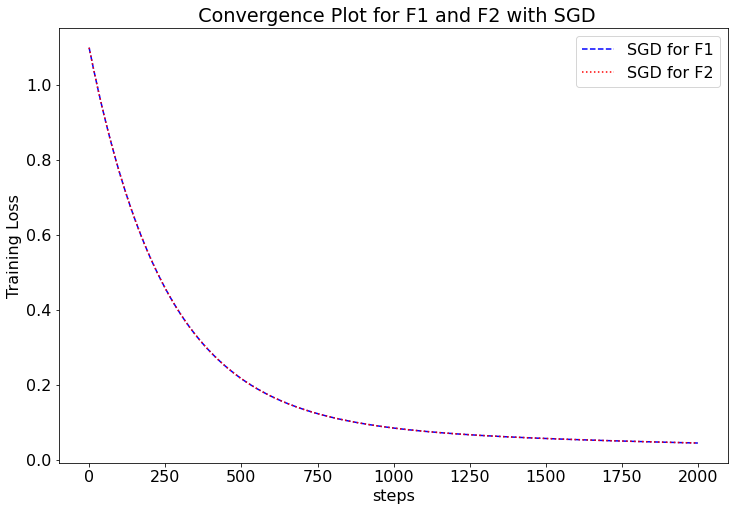

In [ ]:
initial_1 = torch.Tensor([1.0]), torch.Tensor([1.0])
optimizer = torch.optim.SGD([{"params": [initial_1[0]], "lr": 1e-3}, {"params": [initial_1[1]], "lr": 1e-3}])
sgd_f1_vals =  minimizer(f_1, initial_1, optimizer)

initial_2 = torch.Tensor([np.sqrt(2)]), torch.Tensor([0.0])
optimizer = torch.optim.SGD([{"params": [initial_2[0]], "lr": 1e-3}, {"params": [initial_2[1]], "lr": 1e-3}])
sgd_f2_vals =  minimizer(f_2, initial_2, optimizer)

plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(sgd_f1_vals, 'b', label = "SGD for F1", linestyle = '--')
plt.plot(sgd_f2_vals, 'r', label = "SGD for F2", linestyle = ":")
plt.title(" Convergence Plot for F1 and F2 with SGD")
plt.xlabel('steps')
plt.ylabel('Training Loss')
plt.legend()
plt.show()


## Minimizing the SGD with Momentum 0.9

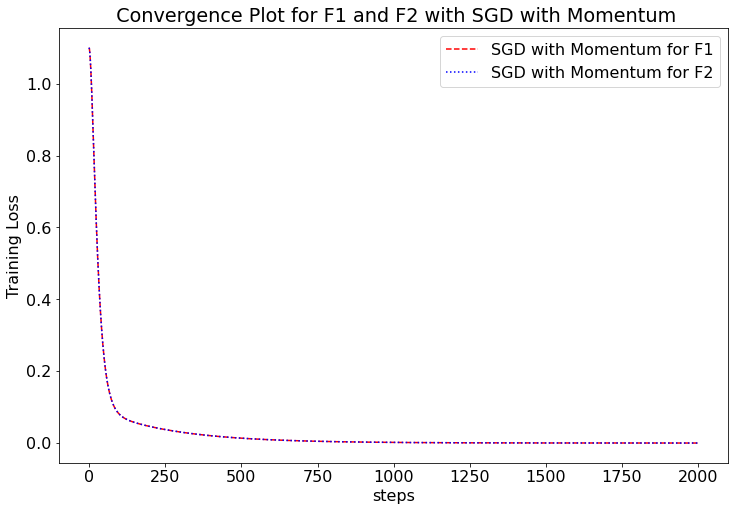

In [ ]:
initial_1 = torch.Tensor([1.0]), torch.Tensor([1.0])
optimizer_1 = torch.optim.SGD([{"params": [initial_1[0]], "lr": 1e-3}, {"params": [initial_1[1]], "lr": 1e-3}], momentum = 0.9)
sgd_momentum_f1_vals =  minimizer(f_1, initial_1, optimizer_1)

initial_2 = torch.Tensor([np.sqrt(2)]), torch.Tensor([0.0])
optimizer_1 = torch.optim.SGD([{"params": [initial_2[0]], "lr": 1e-3}, {"params": [initial_2[1]], "lr": 1e-3}], momentum = 0.9)
sgd_momentum_f1_vals =  minimizer(f_2, initial_2, optimizer_1)

plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(sgd_momentum_f1_vals, 'r', label = "SGD with Momentum for F1", linestyle = '--')
plt.plot(sgd_momentum_f1_vals, 'b', label = "SGD with Momentum for F2", linestyle = ':')
plt.title(" Convergence Plot for F1 and F2 with SGD with Momentum")
plt.xlabel('steps')
plt.ylabel('Training Loss')
plt.legend()
plt.show()


## Minimizing the RMSProp

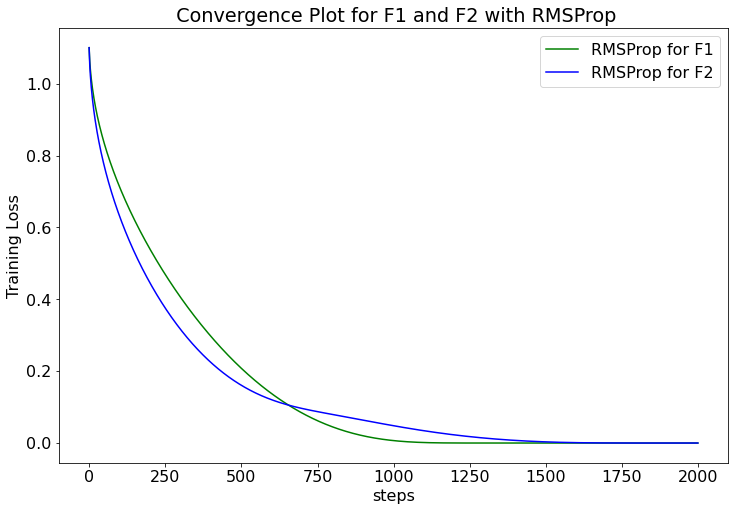

In [ ]:
initial_1 = torch.Tensor([1.0]), torch.Tensor([1.0])
optimizer_2 = torch.optim.RMSprop([{"params": [initial_1[0]], "lr": 1e-3}, {"params": [initial_1[1]], "lr": 1e-3}])
rmsProp_f1_vals =  minimizer(f_1, initial_1, optimizer_2)

initial_2 = torch.Tensor([np.sqrt(2)]), torch.Tensor([0.0])
optimizer_2 = torch.optim.RMSprop([{"params": [initial_2[0]], "lr": 1e-3}, {"params": [initial_2[1]], "lr": 1e-3}])
rmsProp_f2_vals =  minimizer(f_2, initial_2, optimizer_2)

plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(rmsProp_f1_vals, 'g', label = "RMSProp for F1")
plt.plot(rmsProp_f2_vals, 'b', label = "RMSProp for F2")
plt.title(" Convergence Plot for F1 and F2 with RMSProp")
plt.xlabel('steps')
plt.ylabel('Training Loss')
plt.legend()
plt.show()


## Minimizing the Adam with $\beta_1 =0.9$ and $\beta_2 = 0.999$

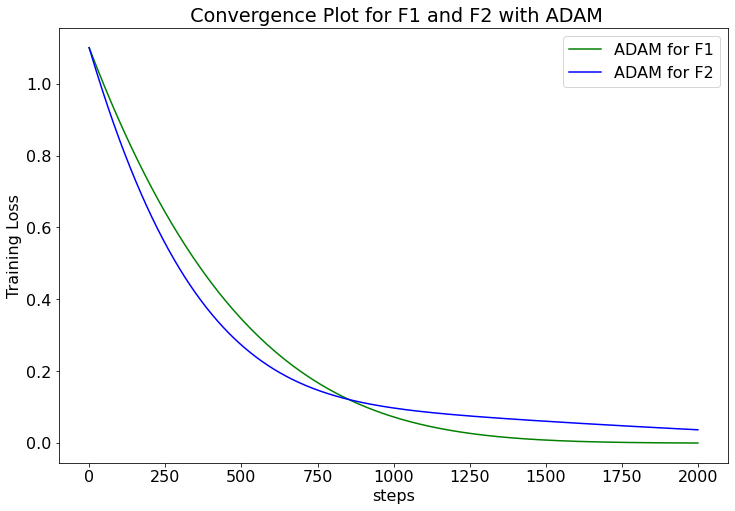

In [ ]:
initial_1 = torch.Tensor([1.0]), torch.Tensor([1.0])
optimizer_3 = torch.optim.Adam([{"params": [initial_1[0]], "lr": 1e-3}, {"params": [initial_1[1]], "lr": 1e-3}], betas=(0.9, 0.999))
adam_f1_vals =  minimizer(f_1, initial_1, optimizer_3)

initial_2 = torch.Tensor([np.sqrt(2)]), torch.Tensor([0.0])
optimizer_3 = torch.optim.Adam([{"params": [initial_2[0]], "lr": 1e-3}, {"params": [initial_2[1]], "lr": 1e-3}], betas=(0.9, 0.999))
adam_f2_vals =  minimizer(f_2, initial_2, optimizer_3)

plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(adam_f1_vals, 'g', label = "ADAM for F1")
plt.plot(adam_f2_vals, 'b', label = "ADAM for F2")
plt.title(" Convergence Plot for F1 and F2 with ADAM")
plt.xlabel('steps')
plt.ylabel('Training Loss')
plt.legend()
plt.show()


## Plotting the $f_1(x,y) = x^2 + 0.1 y^2$  with various varitions in optimizer

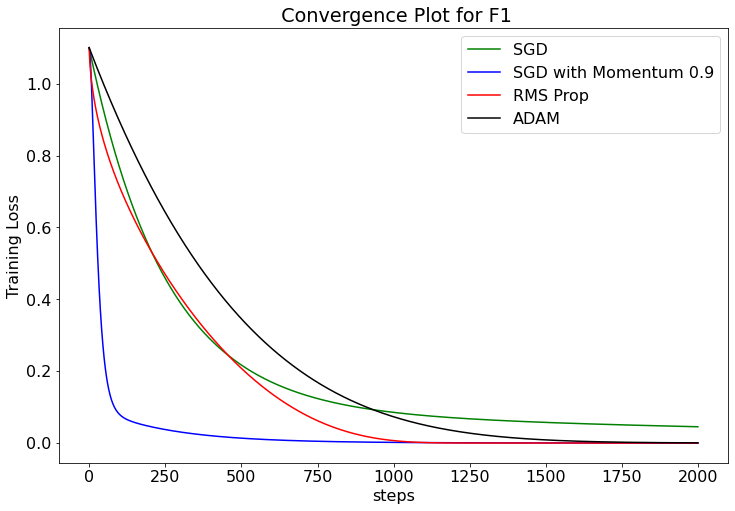

In [ ]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(sgd_f1_vals, 'g', label = 'SGD')
plt.plot(sgd_momentum_f1_vals, 'b', label = "SGD with Momentum 0.9")
plt.plot(rmsProp_f1_vals, 'r', label = "RMS Prop")
plt.plot(adam_f1_vals, 'black', label = "ADAM")
plt.title(" Convergence Plot for F1")
plt.xlabel('steps')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

## Plotting the $f_2(x,y) = \frac{(x-y)^2}{2} + 0.1 \frac{(x+y)^2}{2}$  with various varitions of optimizer

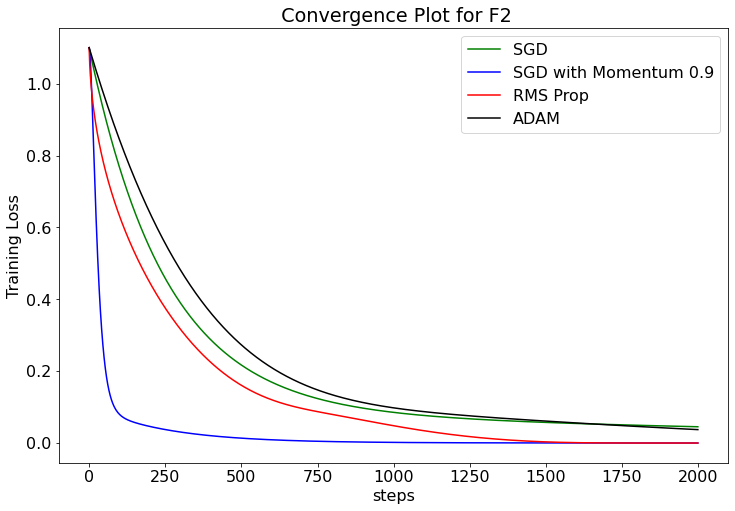

In [ ]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(sgd_f2_vals, 'g', label = "SGD")
plt.plot(sgd_momentum_f2_vals, 'b', label = "SGD with Momentum 0.9")
plt.plot(rmsProp_f2_vals, 'r' , label = "RMS Prop")
plt.plot(adam_f2_vals, 'black', label = "ADAM")
plt.title(" Convergence Plot for F2")
plt.xlabel('steps')
plt.ylabel('Training Loss')
plt.legend()
plt.show()